# Predicting Cell Properties from Protein Mass

In [20]:
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import prot.viz 
colors, palette = prot.viz.bokeh_theme()
color_dict = dict(zip(list(colors)[0::3], [colors[c] for c in list(colors)[0::3]]))
colorlist = [colors[c] for c in list(colors)[0::3]]
prot.viz.plotting_style()

from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

## Outline
Lets begin by look the the reported proteomic data as reported and that following our correction to maintain cellular protein concentration. From there, lets try to reason out what we would have expected for total protein mass using the cell volume scaling laws from Taheri-Araghi et al. (lab of Suckjoon Jun, UCSD). 

In [4]:
# Load the compiled data 
data = pd.read_csv('../../data/compiled_absolute_measurements.csv')

# Load the original dataset with aboslute measurements
data_orig = pd.read_csv('../../data/compiled_datasets.csv')


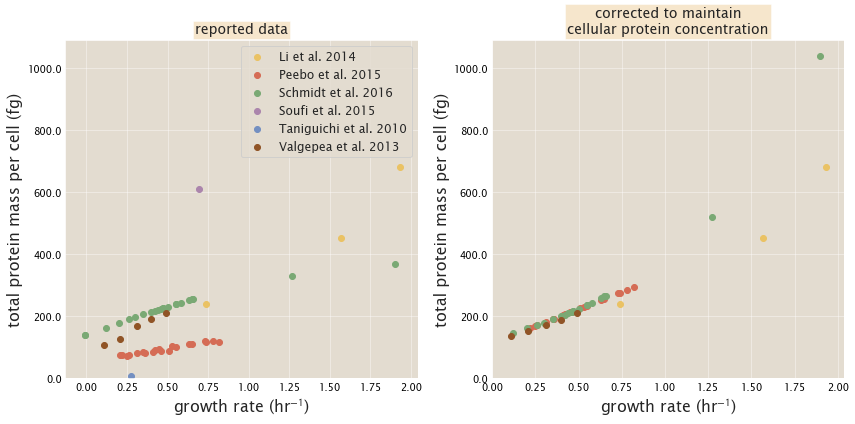

In [185]:
color_dict = dict(zip(data_orig.dataset.unique(), colorlist))

fig, ax = plt.subplots(1,2,figsize=(12,6))

for i, data_ in data_orig.groupby(['dataset_name', 'condition', 'growth_rate_hr']):
    if i[0] == 'Li et al. 2014':
        tot_mass = data_[['dataset', 'condition', 'growth_rate_hr', 
                          'gene_name', 'fg_per_cell']].copy().drop_duplicates().\
                            fg_per_cell.sum()
    else:
        tot_mass = data_[['dataset', 'condition', 'growth_rate_hr', 
                          'gene_name', 'reported_fg_per_cell']].copy().drop_duplicates().\
                            reported_fg_per_cell.sum()
        
    ax[0].scatter(data_.growth_rate_hr.unique()[0], tot_mass, 
                color = color_dict[data_.dataset.unique()[0]], 
               label = data_.dataset_name.unique()[0])
    
for i, data_ in data.groupby(['dataset_name', 'condition', 'growth_rate_hr']):
    tot_mass = data_[['dataset', 'condition', 'growth_rate_hr', 'gene_name', 
                      'fg_per_cell']].copy().drop_duplicates().fg_per_cell.sum()
    ax[1].scatter(data_.growth_rate_hr.unique()[0], tot_mass, 
                color = color_dict[data_.dataset.unique()[0]], 
               label = data_.dataset_name.unique()[0])
    
for ax_ in ax:
    ax_.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax_.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    ax_.set_ylabel('total protein mass per cell (fg)', fontsize = 16)
    ax_.set_xlabel('growth rate (hr$^{-1}$)', fontsize = 16)
    
    ax_.grid(True,  alpha = 0.5)

# Put a legend to the right of the current axis
lgd = ax[0].legend( loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys(), fontsize = 12)

ax[0].set_title('reported data',
            bbox={'facecolor': '#EFCE9A', 'alpha': 0.5, 'pad': 2},
               fontsize = 14)

ax[1].set_title('corrected to maintain\ncellular protein concentration',
            bbox={'facecolor': '#EFCE9A', 'alpha': 0.5, 'pad': 2},
               fontsize = 14)

ax[0].set_ylim(0,1090)
ax[1].set_ylim(0,1090)

plt.tight_layout()


## Attempting to predict cell mass

Okay, now lets try to predict cell mass using the volume-growth rate scaling that has been demonstrated for bacteria, and particularly for $E. coli$ in Suckjoon Jun's lab. Specifically, the empirical law shows that cell volume, $V$, increases exponentially, following,

\begin{equation*}
V = S_0 \cdot 2^{\tau_{cyc} / \tau}.
\end{equation*}

where $S_0$ can be considered as the smallest 'unit cell' for the growing bacterium, $\tau_{cyc}$ is the time period of the cell cycle (combined process of chromosome replication and cell division), while $\tau$ is the average doubling time. Note that the growth rate of the cell is given by $\lambda = ln(2)/\tau$. In the work of Taheri-Araghi et al., they used a microfluidic mother machine to vary growth rate (via nutrient conditions) and reported the volume scaling as,

\begin{equation*}
V = 0.28 \cdot 2^{1.1 \cdot \lambda}.
\end{equation*}

We know that bacterial mass density is roughly 1.1 g/ml, though lets assume it varies from 1.05 to 1.15. We will also assume that dry mass amounts to 30% of the total mass. Given a cell volume, as estimated above, we can directly calculate the cell mass.

(0, 500)

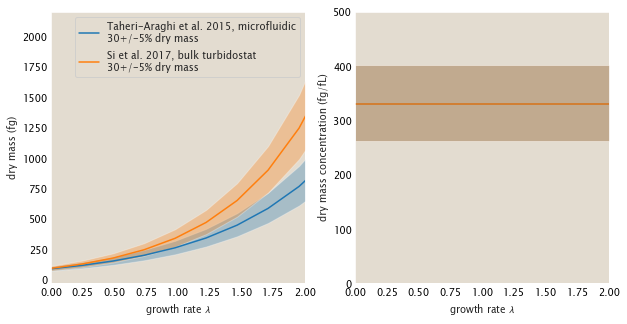

In [187]:
density = [1.05, 1.1, 1.15]
frac_dry = [0.25,0.3,0.35]
growth_rate = np.linspace(0,2.2, 10)

vol_TA = 0.27 * 2**(1.1  * growth_rate / np.log(2))
mass_dry_TA = [vol_TA * frac_dry[i] * density[i] * 1000 for i in np.arange(3)]

vol_Si = 0.28 * np.exp(1.33  * growth_rate)
mass_dry_Si = [vol_Si * frac_dry[i] * density[i] * 1000 for i in np.arange(3)]

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].plot(growth_rate, mass_dry_TA[1], label = 'Taheri-Araghi et al. 2015, microfluidic\n30+/-5% dry mass')
ax[0].fill_between(growth_rate, y1 = mass_dry_TA[0], y2 = mass_dry_TA[2], alpha = 0.3)
ax[0].plot(growth_rate, mass_dry_Si[1], label = 'Si et al. 2017, bulk turbidostat\n30+/-5% dry mass')
ax[0].fill_between(growth_rate, y1 = mass_dry_Si[0], y2 = mass_dry_Si[2], alpha = 0.3)

ax[0].set_xlabel(r'growth rate $\lambda$')
ax[0].set_ylabel('dry mass (fg)')
ax[0].legend()

ax[1].plot(growth_rate, mass_dry_TA[1]/vol_TA, label = 'mass conc.')
ax[1].fill_between(growth_rate, y1 = mass_dry_TA[0]/vol_TA, y2 = mass_dry_TA[2]/vol_TA, alpha = 0.3)
ax[1].plot(growth_rate, mass_dry_Si[1]/vol_Si, label = 'mass conc.')
ax[1].fill_between(growth_rate, y1 = mass_dry_Si[0]/vol_Si, y2 = mass_dry_Si[2]/vol_Si, alpha = 0.3)

ax[1].set_xlabel(r'growth rate $\lambda$')
ax[1].set_ylabel('dry mass concentration (fg/fL)')


for ax_ in ax:
    ax_.set_xlim(0,2.0)
    
ax[1].set_ylim(0,500)

Next lets try to estimate the total protein and RNA mass/ concentrations. Here we will approximate the total protein + RNA mass as 70% of the total dry mass, and use the mass ratio of RNA/ protein from Scott et al., to predict protein and RNA abundance. 

In [178]:

from scipy import stats
# # rough estimate based on Fig. 1A of Scott et al. 2010 
# RNA_protein_ratio_data_x = [0.5, 1.5]
# RNA_protein_ratio_data = [0.2, 0.4]
# slope, intercept, _, _, _ = stats.linregress(RNA_protein_ratio_data_x,
#                                                 RNA_protein_ratio_data)

#  estimate based on MG1655. data in SI tables of Si et al. 2010 
RNA_protein_ratio_data_x = [0.38, 0.69, 0.83, 1.091, 1.7619]
RNA_protein_ratio_data = [0.16, 0.215, 0.28, 0.29, 0.43]
slope, intercept, _, _, _ = stats.linregress(RNA_protein_ratio_data_x,
                                                RNA_protein_ratio_data)

RNA_protein_ratio = slope * growth_rate + intercept

# estimate mass:

mass_RNA_protein = [(mass_dry_Si[i] * 0.9) for i in np.arange(3)]

mass_RNA = [(RNA_protein_ratio * mass_RNA_protein[i]) / (1+ RNA_protein_ratio) for i in np.arange(3)]
mass_protein = [ (mass_RNA_protein[i]/ (1+RNA_protein_ratio))  for i in np.arange(3)]



# As an aside
# Biology by the numbers,  Sinauer, 1990 (BNID 104954)
# growth rate ln2/(40/60) ~ 1 ; their RNA/protein is ~0.36 measured which seems on target
# frac of mass that is protein is 55 %
# frac mass that is protein and RNA is 75 %


(0, 360)

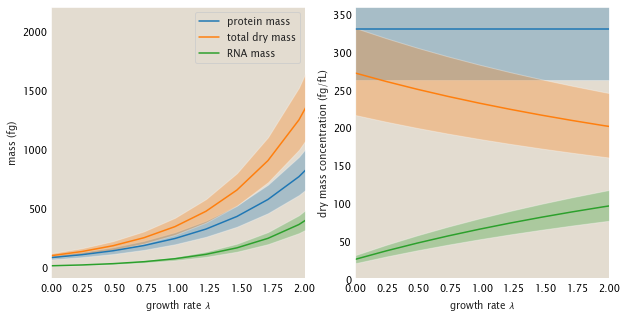

In [179]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))


ax[0].plot(growth_rate, mass_protein[1], label = 'protein mass')
ax[0].fill_between(growth_rate, y1 = mass_protein[0], y2 = mass_protein[2], alpha = 0.3)
ax[0].plot(growth_rate, mass_dry_Si[1], label = 'total dry mass')
ax[0].fill_between(growth_rate, y1 = mass_dry_Si[0], y2 = mass_dry_Si[2], alpha = 0.3)
ax[0].plot(growth_rate, mass_RNA[1], label = 'RNA mass')
ax[0].fill_between(growth_rate, y1 = mass_RNA[0], y2 = mass_RNA[2], alpha = 0.3)

ax[0].set_xlabel(r'growth rate $\lambda$')
ax[0].set_ylabel('mass (fg)')
ax[0].legend()

ax[1].plot(growth_rate, mass_dry_Si[1]/vol_Si, label = 'dry mass')
ax[1].fill_between(growth_rate, y1 = mass_dry_Si[0]/vol_Si, y2 = mass_dry_Si[2]/vol_Si, alpha = 0.3)

ax[1].plot(growth_rate, mass_protein[1]/vol_Si, label = 'dry mass')
ax[1].fill_between(growth_rate, y1 = mass_protein[0]/vol_Si, y2 = mass_protein[2]/vol_Si, alpha = 0.3)

ax[1].plot(growth_rate, mass_RNA[1]/vol_Si, label = 'dry mass')
ax[1].fill_between(growth_rate, y1 = mass_RNA[0]/vol_Si, y2 = mass_RNA[2]/vol_Si, alpha = 0.3)



ax[1].set_xlabel(r'growth rate $\lambda$')
ax[1].set_ylabel('dry mass concentration (fg/fL)')


for ax_ in ax:
    ax_.set_xlim(0,2.0)
    
ax[1].set_ylim(0,360)

Okay, now lets just plot our data on total protein mass and compare against the prtein mass predicted above.

In [180]:
colorlist

['#7AA974', '#EAC264', '#738FC1', '#D56C55', '#AB85AC', '#905426']

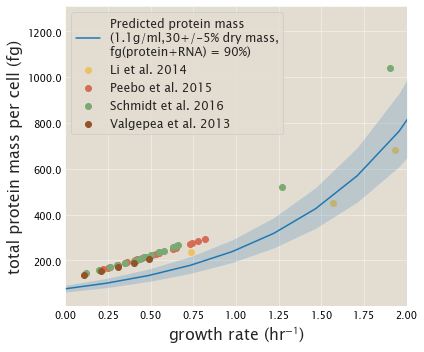

In [182]:
color_dict = dict(zip(data_orig.dataset.unique(), colorlist))

fig, ax = plt.subplots(1,1,figsize=(6,5))


for i, data_ in data.groupby(['dataset_name', 'condition', 'growth_rate_hr']):
    tot_mass = data_[['dataset', 'condition', 'growth_rate_hr', 'gene_name', 
                      'fg_per_cell']].copy().drop_duplicates().fg_per_cell.sum()
    ax.scatter(data_.growth_rate_hr.unique()[0], tot_mass, 
                color = color_dict[data_.dataset.unique()[0]], 
               label = data_.dataset_name.unique()[0])
    
ax.plot(growth_rate, mass_protein[1], label = 'Predicted protein mass\n(1.1g/ml,30+/-5% dry mass,\nfg(protein+RNA) = 90%)')
ax.fill_between(growth_rate, y1 = mass_protein[0], y2 = mass_protein[2], alpha = 0.2)


for ax_ in [ax]:
    ax_.yaxis.set_minor_formatter(FormatStrFormatter("%.1f"))
    ax_.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    ax_.set_ylabel('total protein mass per cell (fg)', fontsize = 16)
    ax_.set_xlabel('growth rate (hr$^{-1}$)', fontsize = 16)
    
    ax_.grid(True,  alpha = 0.5)
    ax_.set_xlim(0,2)

# Put a legend to the right of the current axis
lgd = ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), fontsize = 12)



plt.tight_layout()

# Ignore

In [208]:
import geopandas as gpd
from descartes import PolygonPatch
treemap = gpd.read_file('../../data/voronoi_map_data/treemap_schmidt_2016_glucose_0.58_complete.geojson',
                    driver='GeoJSON')


In [209]:
treemap

,index,level,cog_category,cog_class,cog_dict,gene_name,mass_frac,mass_frac_tot,cumsum,index_,geometry
0,0,0,None,Not Assigned,0.0,None,0.011021,0.011021,NaN,NaN,"POLYGON ((-2.00788 -15.00000, -15.00000 -15.00..."
1,1,0,None,cellular processes and signaling,3.0,None,0.183602,0.183602,NaN,NaN,"POLYGON ((2.63284 15.00000, 15.00000 15.00000,..."
2,2,0,None,function unknown,5.0,None,0.012688,0.012688,NaN,NaN,"POLYGON ((15.00000 -10.95588, 15.00000 -15.000..."
3,3,0,None,general function prediction only,4.0,None,0.013472,0.013472,NaN,NaN,"POLYGON ((-15.00000 10.15138, -15.00000 15.000..."
4,4,0,None,information storage and processing,1.0,None,0.312258,0.312258,NaN,NaN,"POLYGON ((15.00000 0.70907, 15.00000 -10.95588..."
...,...,...,...,...,...,...,...,...,...,...,...
1316,76,2,"translation, ribosomal biogenesis",information storage and processing,1.0,rlmJ,0.000457,0.000066,0.988497,76.0,"POLYGON ((7.08301 -9.37218, 6.45642 -8.59980, ..."
1317,77,2,"translation, ribosomal biogenesis",information storage and processing,1.0,rsmG,0.000454,0.000065,0.988950,77.0,"POLYGON ((13.45069 -4.63131, 12.59625 -4.66392..."
1318,78,2,"translation, ribosomal biogenesis",information storage and processing,1.0,prfA,0.000443,0.000064,0.989393,78.0,"POLYGON ((3.79535 -3.49359, 4.33649 -3.15548, ..."
1319,79,2,"translation, ribosomal biogenesis",information storage and processing,1.0,rlmN,0.000438,0.000063,0.989832,79.0,"POLYGON ((10.09508 -9.80553, 10.03246 -9.09553..."


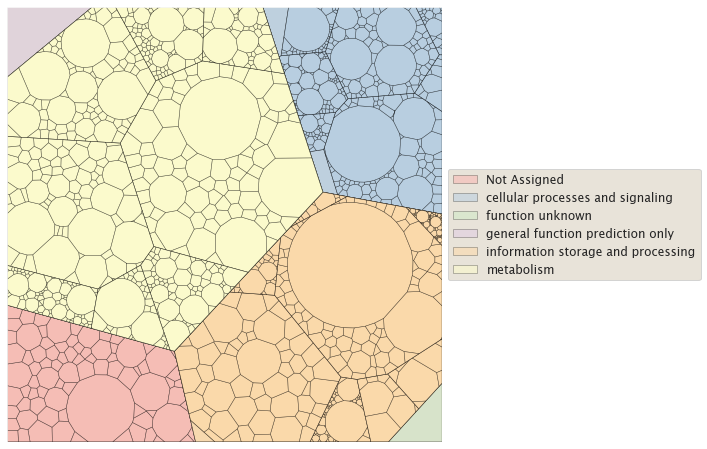

In [210]:
blue = '#6699cc'
# color_dict_ = dict(zip(treemap.cog_class.unique(), colorlist))
color_dict_ = dict(zip(treemap.cog_class.unique(), bokeh.palettes.Pastel1[9]))


fig = plt.figure(figsize=(10,10))
ax = fig.gca()

# import prot.voronoimap as maps
# ax.add_patch(PolygonPatch(maps.border_map(), fc=None, ec = 'k',
#                                   alpha = 0.5, linewidth = 2))

for cog, d in treemap.groupby(['cog_class']):

    for poly in d.geometry:
        ax.add_patch(PolygonPatch(poly, fc=color_dict_[cog], ec = 'k',
                                  alpha = 0.5, linewidth = 0.5,
                                 label = cog))

         
ax.axis('scaled')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-15,15)
ax.set_ylim(-15,15)

# Put a legend to the right of the current axis
lgd = ax.legend( loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(by_label.values(), by_label.keys(), fontsize = 12, 
           loc='center left', bbox_to_anchor=(1, 0.5))

In [194]:
color_dict_

{'Not Assigned': '#7AA974',
 'cellular processes and signaling': '#EAC264',
 'function unknown': '#738FC1',
 'general function prediction only': '#D56C55',
 'information storage and processing': '#AB85AC',
 'metabolism': '#905426'}

In [195]:
colorlist

['#7AA974', '#EAC264', '#738FC1', '#D56C55', '#AB85AC', '#905426']

In [196]:
Pastel1

NameError: name 'Pastel1' is not defined

In [200]:
import bokeh 


['#fbb4ae',
 '#b3cde3',
 '#ccebc5',
 '#decbe4',
 '#fed9a6',
 '#ffffcc',
 '#e5d8bd',
 '#fddaec',
 '#f2f2f2']